### install libraries 

In [1]:
# # !pip install -q git+https://github.com/huggingface/transformers.git
# !pip install -q timm
# !pip install matplotlib
# !pip install pdf2image
# !pip uninstall tokenizers
# !pip install tokenizers==0.14.0
# !pip install ipython-autotime
# !pip install opencv-python
# !pip install pytesseract
# !pip install --upgrade transformers huggingface_hub

### set time 

In [2]:
import time

start_time = time.time()

## Convert the Pdf into Images 

In [3]:
import os
from pdf2image import convert_from_path  #https://pypi.org/project/pdf2image/
%reload_ext autotime



def extract_images_from_pdf(pdf_path):
    """
    Extracts all pages from a PDF file and saves them as images.
    The images are saved in a folder named after the PDF file.

    Args:
    pdf_path (str): The path to the PDF file.
    """

    # Extract the base filename from the PDF path and create a folder name
    pdf_filename = os.path.basename(pdf_path).replace('.pdf', '')
    output_folder = pdf_filename + "_images"

    # Create the output folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Convert PDF pages to images
    images = convert_from_path(pdf_path)

    # Save each page as an image
    for i, image in enumerate(images):
        image.save(os.path.join(output_folder, f"{pdf_filename}_page_{i}.png"), "PNG")
    return output_folder






def extract_pdf_name(pdf_path):
    # Extract the base name of the file
    base_name = os.path.basename(pdf_path)
    # Check if the file is a PDF and return the name without extension
    if base_name.lower().endswith('.pdf'):
        return os.path.splitext(base_name)[0]
    else:
        return "Not a PDF file"






def create_cropped_images_folder(input_folder):
    """
    Creates a folder for cropped images. The new folder's name is based on the input folder's name plus '_cropimg'.

    Args:
    input_folder (str): The path to the folder created by extract_images_from_pdf.

    Returns:
    str: The path of the newly created folder for cropped images.
    """

    # Extract the directory of the input folder and its name
    parent_dir = os.path.dirname(input_folder)
    input_folder_name = os.path.basename(input_folder)

    # Create a new folder name
    new_folder_name = input_folder_name + "_cropimg"
    new_folder_path = os.path.join(parent_dir, new_folder_name)

    # Create the new folder if it does not exist
    if not os.path.exists(new_folder_path):
        os.makedirs(new_folder_path)

    return new_folder_path


# output_folder = create_cropped_images_folder(input_folder)
# print("Crop images folder created at:", output_folder)



time: 0 ns (started: 2024-03-15 10:31:28 +01:00)


In [4]:
# import os

# def create_crop_table_images_folder(pdf_path):
#     """
#     Creates a folder inside the input folder of the PDF file. 
#     The new folder's name is based on the input folder's name plus 'croptableimg'.

#     Args:
#     pdf_path (str): The path to the PDF file.

#     Returns:
#     str: The path of the newly created folder.
#     """

#     # Extract the directory of the input PDF
#     input_dir = os.path.dirname(pdf_path)
#     input_folder_name = os.path.basename(input_dir)

#     # Create a new folder name
#     new_folder_name = input_folder_name + "croptableimg"
#     new_folder_path = os.path.join(input_dir, new_folder_name)

#     # Create the new folder if it does not exist
#     if not os.path.exists(new_folder_path):
#         os.makedirs(new_folder_path)

#     return new_folder_path

# # Example usage
# pdf_path = r"C:\A\00Master\Demo\data acc\DIN EN 206.pdf"
# new_folder_path = create_crop_table_images_folder(pdf_path)
# print("New folder created at:", new_folder_path)


time: 0 ns (started: 2024-03-15 10:31:28 +01:00)


functions that help

Thoes function based on computer vison functions 
## Overview

This script is designed for extracting table data from an image and converting it into a pandas DataFrame using computer vision techniques and OCR (Optical Character Recognition). It utilizes OpenCV for image preprocessing and table structure detection, pytesseract for text extraction, and pandas for organizing the extracted data into a structured format.

### Functions

- **`preprocess_image(img)`**: Prepares the image for better OCR results by converting it to a binary image using thresholding. This step enhances the contrast between the text and the background to improve text detection accuracy.

- **`extract_table_structure(img_bin_otsu)`**: Identifies the structure of the table by detecting vertical and horizontal lines, which represent the borders of table cells. This function is crucial for understanding the layout of the table and for guiding the text extraction process.

- **`create_dataframe_from_text(text_list, num_columns)`**: Creates a pandas DataFrame from the list of extracted text, arranging the text into the estimated number of columns. This function is responsible for organizing the OCR results into a tabular format that reflects the original table structure.

- **`extract_text_from_boxes(img, boxes, config)`**: Extracts text from specified bounding boxes within the image. It also estimates the number of columns in the table based on the unique positions of these boxes. This function applies OCR to each table cell and collects the results for further processing.

- **`mah(img)`**: This is the main function that ties everything together. It preprocesses the image, extracts the table structure, extracts text from the identified table cells, and finally compiles everything into a DataFrame. This high-level function orchestrates the workflow from image input to structured output.

### Usage

The script is designed to be modular, allowing each function to be individually tested and adjusted based on specific requirements. By processing images of tables through these functions, users can automate the extraction of structured data from unstructured image sources, facilitating data analysis and other applications.


In [5]:
import cv2
import numpy as np
import pytesseract
import pandas as pd


pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
def preprocess_image(img):
    """
    Applies preprocessing steps to the input image for better OCR results.

    Args:
    img (cv2.Image): The input image.

    Returns:
    cv2.Image: The preprocessed image.
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    img_bin = 255 - img
    _, img_bin_otsu = cv2.threshold(img_bin, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    return img_bin_otsu

def extract_table_structure(img_bin_otsu):
    """
    Extracts table structure from the binary image.

    Args:
    img_bin_otsu (cv2.Image): The binary image after thresholding.

    Returns:
    List: List of bounding boxes of table cells.
    """
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, img_bin_otsu.shape[1] // 100))
    eroded_image = cv2.erode(img_bin_otsu, vertical_kernel, iterations=3)
    vertical_lines = cv2.dilate(eroded_image, vertical_kernel, iterations=3)

    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (img_bin_otsu.shape[1] // 100, 1))
    horizontal_lines = cv2.erode(img_bin_otsu, hor_kernel, iterations=5)
    horizontal_lines = cv2.dilate(horizontal_lines, hor_kernel, iterations=5)

    combined = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
    combined = cv2.erode(~combined, kernel, iterations=3)
    _, combined = cv2.threshold(combined, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(combined, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]

    return sorted(bounding_boxes, key=lambda x: x[1])



def create_dataframe_from_text(text_list, num_columns):
    """
    Creates a pandas DataFrame from the list of text.
    Handles cases where num_columns is zero.

    Args:
    text_list (List): List of text strings extracted from the image.
    num_columns (int): Number of columns in the DataFrame.

    Returns:
    pd.DataFrame: The created DataFrame.
    """
    if num_columns == 0:
        print("No columns detected. Returning an empty DataFrame.")
        return pd.DataFrame()

    num_rows = len(text_list) // num_columns
    array = np.array(text_list[:num_rows * num_columns]).reshape(num_rows, num_columns)
    return pd.DataFrame(array)

def extract_text_from_boxes(img, boxes, config):
    """
    Extracts text from the provided bounding boxes and calculates the number of columns.

    Args:
    img (cv2.Image): The original image.
    boxes (List): List of bounding boxes.
    config (str): Configuration string for Tesseract OCR.

    Returns:
    List: List of extracted text strings.
    int: Estimated number of columns in the table.
    """
    text_list = []
    column_positions = []

    for x, y, w, h in boxes:
        if w < 1000 and h < 500:
            roi = img[y:y+h, x:x+w]
            text = pytesseract.image_to_string(roi, config=config)
            text_list.append(text.strip())
            column_positions.append(x)

    # Estimate the number of columns based on unique x positions
    num_columns = len(np.unique(column_positions))

    return text_list, num_columns



def mah(img):
    """
    Main function to extract table data from an image and convert it into a pandas DataFrame.

    Args:
    img (cv2.Image): The input image.

    Returns:
    pd.DataFrame: DataFrame containing the extracted table data.
    """
    custom_config = r'--oem 3 --psm 6'
    preprocessed_img = preprocess_image(img)
    boxes = extract_table_structure(preprocessed_img)
    text_list, num_columns = extract_text_from_boxes(img, boxes, custom_config)

    # Handle the case where no text boxes are detected
    if not boxes:
        print("No text boxes detected. Returning an empty DataFrame.")
        return pd.DataFrame()

    dataframe = create_dataframe_from_text(text_list, num_columns)

    return dataframe








time: 1.89 s (started: 2024-03-15 10:31:28 +01:00)


In [6]:
import cv2
import os
import glob
import torch
import pandas as pd
import numpy as np
import pytesseract
import json
from PIL import Image, ImageDraw, ImageEnhance, ImageFilter, ImageFont
from transformers import DetrImageProcessor, TableTransformerForObjectDetection
from IPython.display import display
import re
import time
start_time = time.time()

# Set pytesseract command
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


pdf_path = r"C:\A\00Master\DIN\Stütze\New folder\DIN 488-2.pdf"

# Define input and output folders
filename = extract_pdf_name(pdf_path)
input_folder = extract_images_from_pdf(pdf_path)
output_folder = r"C:\A\00Master\Demo\data acc\att\output\Extraction"


# Define function to draw text on image
def draw_text_on_image(draw_obj, text, position, font_size=12):
    font = ImageFont.truetype("arial.ttf", font_size)  # Adjust font path as needed
    draw_obj.multiline_text(position, text, fill=(0, 0, 0), font=font)


# Function to extract page number from filename
def extract_page_number(filename):
    parts = filename.split('_')
    if len(parts) > 1:
        page_part = parts[-1]  # Get the last part
        page_number = ''.join(filter(str.isdigit, page_part))  # Extract digits
        return int(page_number) if page_number.isdigit() else 0
    return 0
    
# List all image files in the directory and sort them based on page number
image_files = glob.glob(os.path.join(input_folder, '*.png'))  # Adjust the pattern as needed
image_files.sort(key=extract_page_number)

# Initialize model for table detection
feature_extractor = DetrImageProcessor()
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

# Initialize JSON structure
combined_json = {}

# List all image files in the directory
image_files = glob.glob(os.path.join(input_folder, '*.png'))  # Adjust the pattern as needed

# Process each image file
for file_path in image_files:
    # Load the image
    image = Image.open(file_path).convert("RGB")

    # Detect tables
    encoding = feature_extractor(image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**encoding)

    # Rescale bounding boxes
    width, height = image.size
    target_sizes = [(height, width)]

    results = feature_extractor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]
    high_score_tables = [(score, label, box) for score, label, box in
                         zip(results['scores'].tolist(),
                             results['labels'].tolist(), 
                             results['boxes'].tolist())
                         if score > 0.9]

    # Process and draw text for each table
    tables_json = {}
    image_for_ocr = image.copy()
    draw = ImageDraw.Draw(image_for_ocr)

    if high_score_tables:
        for idx, (_, _, (xmin, ymin, xmax, ymax)) in enumerate(high_score_tables):
            # Adjust the crop area
            xmin -= 20
            ymin -= 20
            xmax += 20
            ymax += 20

            # Crop the table image and process it
            table_img = image.crop((xmin, ymin, xmax, ymax))
            table_img.save(os.path.join(output_folder, f"table_{idx}.png"), "PNG")
            # print(table_img)
            table_img_np = np.array(table_img.convert('L'))
            try:
                df = mah(table_img_np)
                if df is not None and not df.empty:
                    # Convert DataFrame to JSON and store in the dictionary
                    df_json = df.to_json(orient='split')
                    tables_json[f"table_{idx}"] = json.loads(df_json)
            except IndexError as e:
                print(f"Error processing table {idx}: {e}")

            # Cover the table with a white rectangle
            draw.rectangle([xmin, ymin, xmax, ymax], fill=(255, 255, 255))
    

    header_coords = [(0, 0), (image_for_ocr.width, 150)]  # Update these coordinates as needed
    footer_coords = [(0, image_for_ocr.height - 100), (image_for_ocr.width, image_for_ocr.height)]  # Update these coordinates as needed

    # # Draw white rectangles over the unwanted text areas (header and footer)
    draw.rectangle(header_coords, fill=(255, 255, 255))
    draw.rectangle(footer_coords, fill=(255, 255, 255)) 
    # Perform OCR on the image
    custom_config = r'--oem 3 --psm 6'
    # text = pytesseract.image_to_string(image_for_ocr, lang='deu+eng', config=custom_config)
    text = pytesseract.image_to_string(image_for_ocr, lang='deu', config=custom_config)

    # Add text to JSON
    tables_json["text"] = text

    # Add to combined JSON
    combined_json[os.path.basename(file_path)] = tables_json




# Write combined JSON to file
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Define the full path for the JSON file (including the filename)
# Use the filename variable to define the full path for the JSON file
output_json_path = os.path.join(output_folder, f"{filename}.json")


# Write combined JSON to file in the specified directory
with open(output_json_path, 'w') as file:
    json.dump(combined_json, file, indent=4)
elapsed_time = time.time() - start_time
# Print the elapsed time
print(f"Total execution time: {elapsed_time} seconds")

c:\A\00Master\Demo\Data acquisition\Data_acquisition\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from 

No columns detected. Returning an empty DataFrame.
Total execution time: 39.881065130233765 seconds
time: 48 s (started: 2024-03-15 10:31:30 +01:00)


In [7]:
print(f"JSON file saved at {output_json_path}")

JSON file saved at C:\A\00Master\Demo\data acc\att\output\Extraction\DIN 488-2.json
time: 0 ns (started: 2024-03-15 10:32:18 +01:00)


In [13]:
combined_json

{'DIN 488-2_page_0.png': {'text': 'DIN 483-2 D | N\nICS 77.140.15 Ersatz für\nDIN 488-2:1986-06\nBetonstahl —\nBetonstabstahl\nReinforcing steels —\nReinforcing steel bars\nAciers pour beton arme —\nAciers en barres droites\nGesamtumfang 11 Seiten\nNormenausschuss Eisen und Stahl (FES) im DIN\nNormenausschuss Bauwesen (NABau) im DIN\n© DIN Deutsches Institut für Normung e.V. : Jede Art der Vervielfältigung, auch auszugsweise, || I l || II | l\n'},
 'DIN 488-2_page_1.png': {'text': 'Inhalt\nSeite\nVOrWOrt anunnennnsnnennnnnnnnnnnnnnnnnnnnnnnennnnnnnnnnsnnnnnnsnnnnnnnnnnnsnnnnnnsnnnsersnnsnnrnnnsnnsnnnsnnnnnrsnnnnrnersnnsnnsnersersnrnensnnsnnsnnnsnnnnnnnen\n3\n2\nEI\nE\n5\n©\n5\n8\n&\n3\nB\n8\n&\n2\n'},
 'DIN 488-2_page_10.png': {'table_0': {'columns': [0, 1, 2, 3, 4, 5],
   'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
   'data': [['Bezogene\nRippenflache*\nJR',
     'Rippenabstand?\n(Richtwerte)\nc\nmm',
     'Kopfbreite?\n(Richtwerte)\nb\nmm',
     'Hohe (Richtwerte)',
     'Nenn-\

time: 0 ns (started: 2024-03-15 10:40:26 +01:00)


### For one image for showing how the pipeline work 

In [9]:
# from PIL import Image

# # Specify the path to the image you want to process
# image_path = r"C:\A\00Master\Demo\data acc\att\DIN 1045-2_page_65.png"  # Replace with the actual path to your image

# # Load the image
# image = Image.open(image_path).convert("RGB")  # Make sure the image is in RGB mode

# image


time: 0 ns (started: 2024-03-15 10:32:18 +01:00)


In [10]:
# import cv2
# import os
# import glob
# import torch
# import pandas as pd
# import numpy as np
# import pytesseract
# import json
# from PIL import Image, ImageDraw, ImageEnhance, ImageFilter, ImageFont
# from transformers import DetrImageProcessor, TableTransformerForObjectDetection
# from IPython.display import display
# import re
# import time
# start_time = time.time()

# # Set pytesseract command
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'



# # Define function to draw text on image
# def draw_text_on_image(draw_obj, text, position, font_size=12):
#     font = ImageFont.truetype("arial.ttf", font_size)  # Adjust font path as needed
#     draw_obj.multiline_text(position, text, fill=(0, 0, 0), font=font)


# # Function to extract page number from filename
# def extract_page_number(filename):
#     parts = filename.split('_')
#     if len(parts) > 1:
#         page_part = parts[-1]  # Get the last part
#         page_number = ''.join(filter(str.isdigit, page_part))  # Extract digits
#         return int(page_number) if page_number.isdigit() else 0
#     return 0
    
# # List all image files in the directory and sort them based on page number


# # Initialize model for table detection
# feature_extractor = DetrImageProcessor()
# model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

# # Initialize JSON structure
# combined_json = {}



#     # Detect tables
# encoding = feature_extractor(image, return_tensors="pt")
# with torch.no_grad():
#     outputs = model(**encoding)

#     # Rescale bounding boxes
# width, height = image.size
# target_sizes = [(height, width)]

# results = feature_extractor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]
# high_score_tables = [(score, label, box) for score, label, box in
#                          zip(results['scores'].tolist(),
#                              results['labels'].tolist(), 
#                              results['boxes'].tolist())
#                          if score > 0.9]

#     # Process and draw text for each table
# tables_json = {}
# image_for_ocr = image.copy()
# draw = ImageDraw.Draw(image_for_ocr)

# if high_score_tables:
#     for idx, (_, _, (xmin, ymin, xmax, ymax)) in enumerate(high_score_tables):
#             # Adjust the crop area
#         xmin -= 20
#         ymin -= 20
#         xmax += 20
#         ymax += 20

#             # Crop the table image and process it
#         table_img = image.crop((xmin, ymin, xmax, ymax))
#         table_img.save(os.path.join(output_folder, f"table_{idx}.png"), "PNG")
#             # print(table_img)
#         table_img_np = np.array(table_img.convert('L'))
#         try:
#             df = mah(table_img_np)
#             if df is not None and not df.empty:
#                     # Convert DataFrame to JSON and store in the dictionary
#                 df_json = df.to_json(orient='split')
#                 tables_json[f"table_{idx}"] = json.loads(df_json)
#         except IndexError as e:
#             print(f"Error processing table {idx}: {e}")

#             # Cover the table with a white rectangle
#     draw.rectangle([xmin, ymin, xmax, ymax], fill=(255, 255, 255))
    

# header_coords = [(0, 0), (image_for_ocr.width, 150)]  # Update these coordinates as needed
# footer_coords = [(0, image_for_ocr.height - 100), (image_for_ocr.width, image_for_ocr.height)]  # Update these coordinates as needed

#     # # Draw white rectangles over the unwanted text areas (header and footer)
# draw.rectangle(header_coords, fill=(255, 255, 255))
# draw.rectangle(footer_coords, fill=(255, 255, 255)) 
#     # Perform OCR on the image
# custom_config = r'--oem 3 --psm 6'
#     # text = pytesseract.image_to_string(image_for_ocr, lang='deu+eng', config=custom_config)
# text = pytesseract.image_to_string(image_for_ocr, lang='deu', config=custom_config)

    

#     # Add text to JSON
# tables_json["text"] = text

#     # Add to combined JSON
# combined_json[os.path.basename(file_path)] = tables_json




# # Write combined JSON to file
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# # Define the full path for the JSON file (including the filename)
# # Use the filename variable to define the full path for the JSON file
# output_json_path = os.path.join(output_folder, "Example.'json")


# # Write combined JSON to file in the specified directory
# with open(output_json_path, 'w') as file:
#     json.dump(combined_json, file, indent=4)
# elapsed_time = time.time() - start_time
# # Print the elapsed time
# print(f"Total execution time: {elapsed_time} seconds")

time: 16 ms (started: 2024-03-15 10:32:18 +01:00)


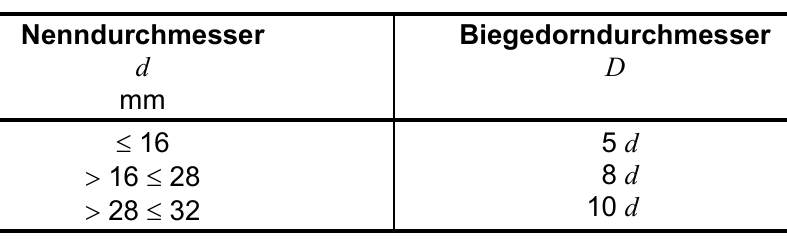

time: 15 ms (started: 2024-03-15 10:32:18 +01:00)


In [11]:
table_img

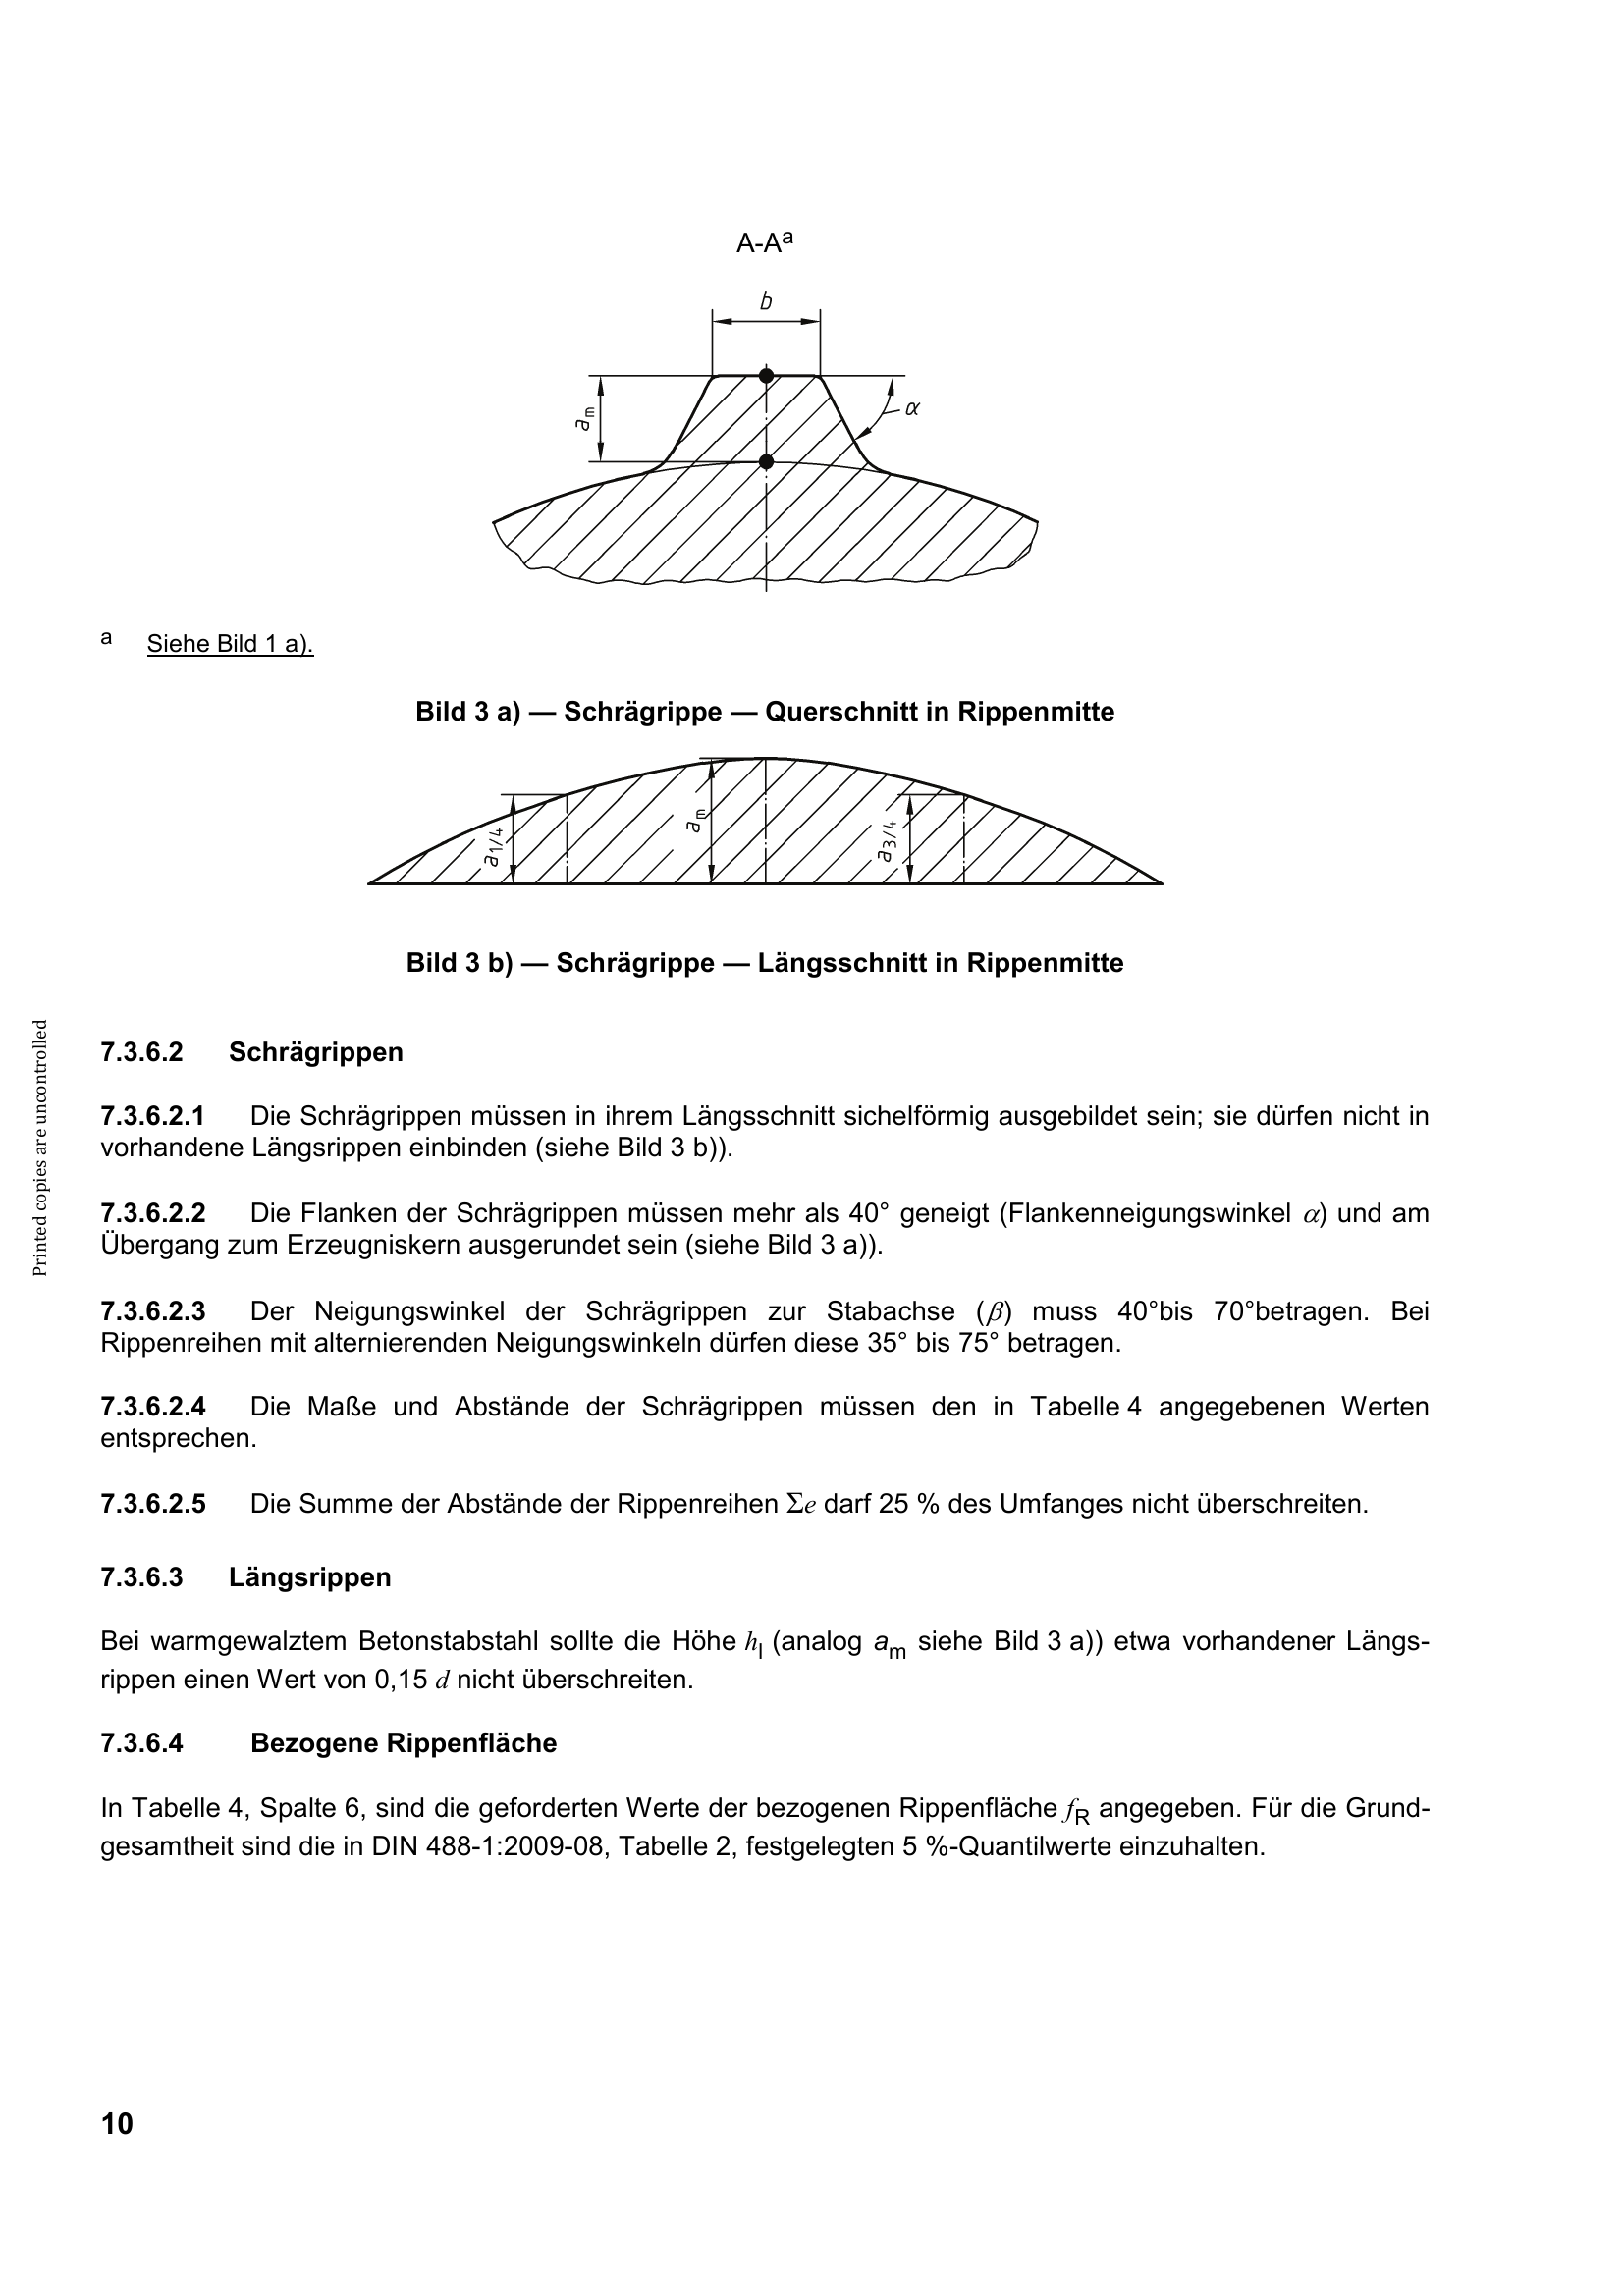

time: 94 ms (started: 2024-03-15 10:32:18 +01:00)


In [12]:
image_for_ocr